# Granger Causality Estimation:

### Purpose
This is a walk-through notebook on *Granger method of causality* for two-channel time series data, implemented in Julia-Language.


### Acknowledgement
This work was funded by the German Federal Ministry of Education and Research ([BMBF](https://www.bmbf.de/)) in the project ALICE III under grant ref. 01IS18049B.

### Load packages

In [1]:
using TimeSeriesCausality
using Distributions: MvNormal
using Plots: plot, plot!
;

### Data
We will generate (simulate) 1e6 two-channel samples using a design (evolution) matrix A of order 3. where:
- channel 1 is the causal (independent) time series
- channel 2 is the effect (dependent) time series

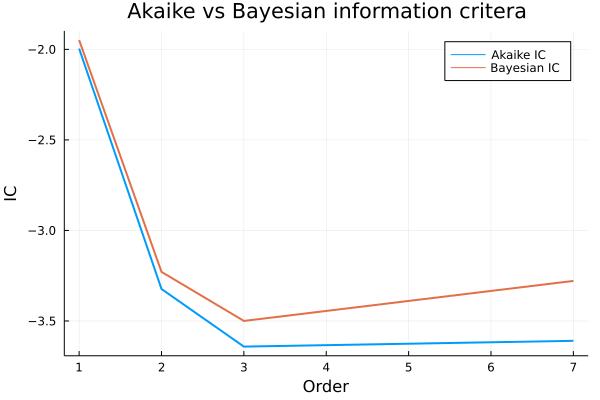

In [2]:
# data generation
time_steps = 1000000  # number of time steps
segment_length = 1000  # segment length
noise_cov = MvNormal([0.25 0.0; 0.0 0.64])  # uncorrelated Cov matrix of noise
noise = rand(noise_cov, time_steps)'  # sampling from the noise distribution

# pre-allocation and initial values
signal = zeros(time_steps, 2)
signal[1:3, :] = rand(3, 2) + noise[1:3, :]

# design (evolution) matrix
#            Channel 1     Channel 2
#          t-1  t-2  t-3  t-1  t-2  t-3
designer = [0.4 -0.6  0.8  0.0  0.0  0.0;  # Channel 1
            0.5  0.9  0.0  0.0  0.0  0.7]  # Channel 2

# simulation
for t in 4:time_steps
    signal[t, :] = designer * reshape(signal[t-3:t-1, :], :, 1) + noise[t, :]
end

order_range = 1:7

# Akaike information criterion
aic = granger_aic(signal, order_range, segment_length)

# Bayesian information criterion
bic = granger_bic(signal, order_range, segment_length)

plot(order_range, [aic, bic],
     title = "Akaike vs Bayesian information critera",
     label = ["Akaike IC" "Bayesian IC"],
     xlabel = "Order",
     ylabel = "IC",
     lw = 2)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*